In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
df = pd.read_csv("../logs/cross_period_evaluation_results.csv")


#mean across seeds
avg_stats = (
    df.groupby(["train_year", "test_year"], as_index=False)[["accuracy", "f1_score", "auc"]]
    .mean()
)

#cross_accuracy = avg_stats[]

#standard deviation across seeds
std_stats = (
    df.groupby(["train_year", "test_year"])[["accuracy", "f1_score", "auc"]]
    .std()
)

Aggregating stats

In [4]:
cross_year_df = avg_stats.sort_values(by=['train_year', 'test_year'])

models = ["svm"]
base_dir = Path("models_avg_results")

for model in models:
    model_file = base_dir / f"tfidf_{model}_performance_avg.csv"
    df = pd.read_csv(model_file)
    avg_stats_same_year = df[["year", "accuracy"]]

same_year_df = pd.DataFrame({
    'train_year': avg_stats_same_year['year'],
    'test_year': avg_stats_same_year['year'],  # Use 'year' for both train and test
    'accuracy': avg_stats_same_year['accuracy'],
    'f1_score': np.nan,  # update with all the data if you want
    'auc': np.nan
})

final_df = pd.concat([cross_year_df, same_year_df], ignore_index=True).sort_values(by=["train_year", "test_year"])
print(final_df)


      train_year  test_year  accuracy  f1_score       auc
1260          76         76  0.539267       NaN       NaN
0             76         77  0.531833  0.529167  0.550233
1             76         78  0.523000  0.518833  0.547300
2             76         79  0.549033  0.541133  0.580367
3             76         80  0.499433  0.494000  0.539467
...          ...        ...       ...       ...       ...
1256         111        107  0.501800  0.513500  0.550833
1257         111        108  0.510133  0.529133  0.546900
1258         111        109  0.508400  0.535033  0.576400
1259         111        110  0.624700  0.640133  0.739800
1295         111        111  0.747233       NaN       NaN

[1296 rows x 5 columns]


Generating model performance analysis...

Creating heatmap...


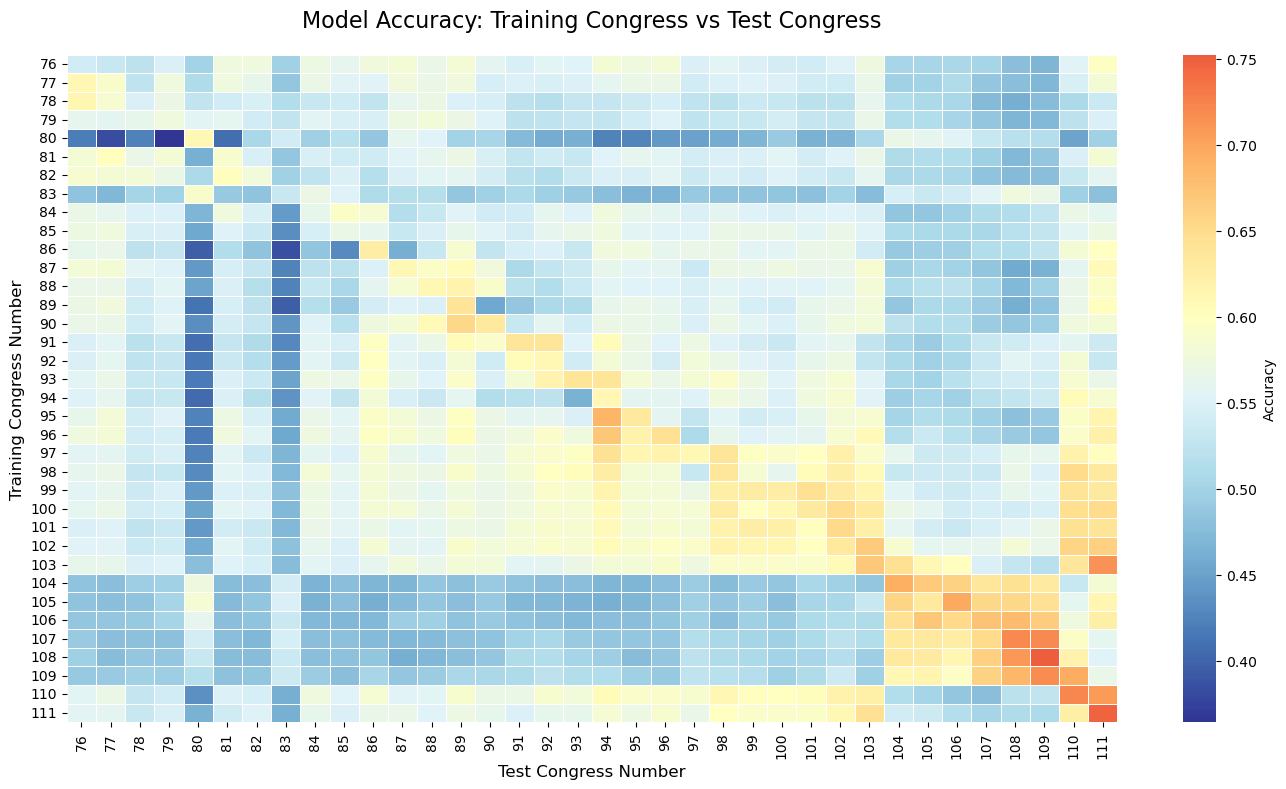

Creating performance trends...


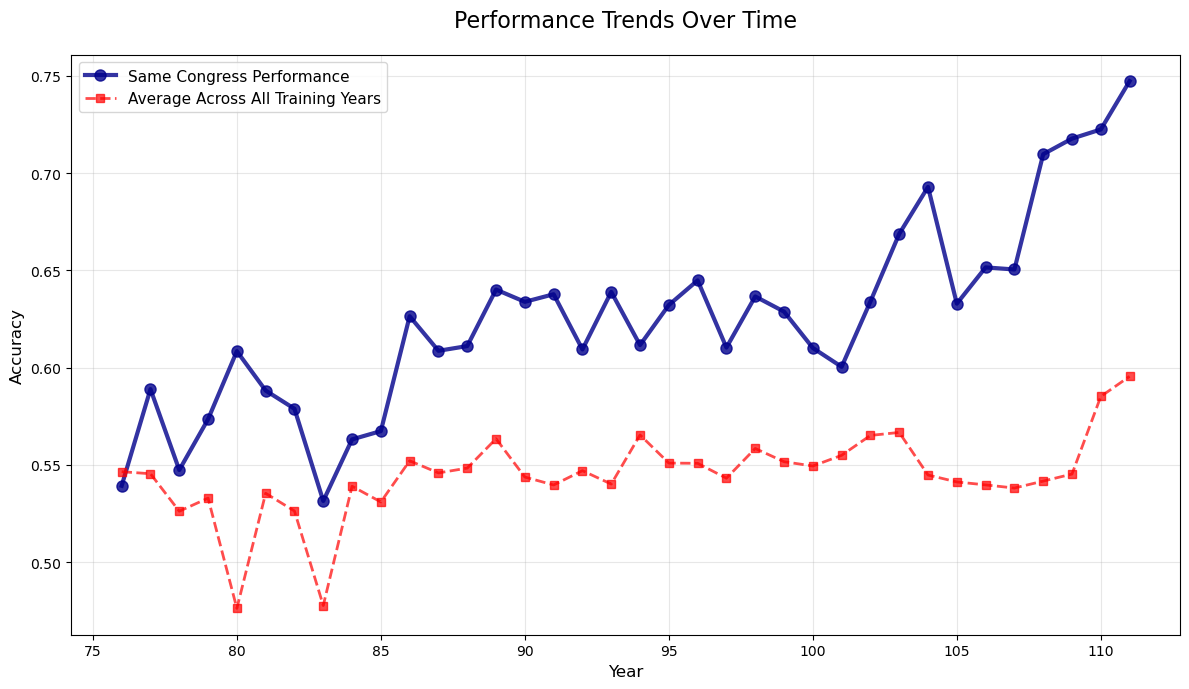

Generating summary statistics...
MODEL PERFORMANCE SUMMARY

🏆 BEST PERFORMANCE:
   Accuracy: 0.7522
   Train Year: 108
   Test Year: 109
   Time Gap: 1 years

📉 WORST PERFORMANCE:
   Accuracy: 0.3643
   Train Year: 80
   Test Year: 79
   Time Gap: -1 years

📊 SAME YEAR vs CROSS YEAR COMPARISON:
   Same Year - Mean: 0.6248 (±0.0503)
   Cross Year - Mean: 0.5423 (±0.0497)
   Performance Gap: 0.0825 (15.2% higher for same year)


In [5]:
def create_heatmap(df):
    """Create a heatmap showing training year vs test year performance"""
    # Pivot the data to create a matrix
    pivot_df = df.pivot(index='train_year', columns='test_year', values='accuracy')
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_df, 
                annot=False, 
                fmt='.3f', 
                cmap='RdYlBu_r',  # Red-Yellow-Blue reversed (higher values are blue)
                center=0.6,  # Adjust based on your data range
                cbar_kws={'label': 'Accuracy'},
                linewidths=0.5)
    
    plt.title('Model Accuracy: Training Congress vs Test Congress', fontsize=16, pad=20)
    plt.xlabel('Test Congress Number', fontsize=12)
    plt.ylabel('Training Congress Number', fontsize=12)
    plt.tight_layout()
    return plt

def create_performance_trends(df):
    """Create performance trends showing same-year vs cross-year performance"""
    plt.figure(figsize=(12, 7))
    
    # Same year performance (diagonal elements)
    same_year_perf = df[df['train_year'] == df['test_year']].copy()
    if not same_year_perf.empty:
        plt.plot(same_year_perf['train_year'], same_year_perf['accuracy'], 
                'o-', label='Same Congress Performance', linewidth=3, markersize=8, 
                color='darkblue', alpha=0.8)
    
    # Average performance for each test year across all training years
    avg_perf = df.groupby('test_year')['accuracy'].mean().reset_index()
    plt.plot(avg_perf['test_year'], avg_perf['accuracy'], 
            's--', label='Average Across All Training Years', 
            linewidth=2, markersize=6, color='red', alpha=0.7)
    
    plt.title('Performance Trends Over Time', fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt

def create_summary_stats(df):
    """Create summary statistics focusing on best and worst performance"""
    
    # Find best and worst performance
    best_idx = df['accuracy'].idxmax()
    worst_idx = df['accuracy'].idxmin()
    
    best_performance = df.loc[best_idx]
    worst_performance = df.loc[worst_idx]
    
    # Same-year performance stats
    same_year = df[df['train_year'] == df['test_year']].copy()
    
    # Cross-year performance stats (excluding same year)
    cross_year = df[df['train_year'] != df['test_year']].copy()
    
    summary_stats = {
        'Best Performance': {
            'Accuracy': f"{best_performance['accuracy']:.4f}",
            'Train Year': int(best_performance['train_year']),
            'Test Year': int(best_performance['test_year']),
            'Time Gap': int(best_performance['test_year'] - best_performance['train_year'])
        },
        'Worst Performance': {
            'Accuracy': f"{worst_performance['accuracy']:.4f}",
            'Train Year': int(worst_performance['train_year']),
            'Test Year': int(worst_performance['test_year']),
            'Time Gap': int(worst_performance['test_year'] - worst_performance['train_year'])
        },
        'Same Year Performance': {
            'Mean Accuracy': f"{same_year['accuracy'].mean():.4f}" if not same_year.empty else "N/A",
            'Std Accuracy': f"{same_year['accuracy'].std():.4f}" if not same_year.empty else "N/A",
            'Count': len(same_year)
        },
        'Cross Year Performance': {
            'Mean Accuracy': f"{cross_year['accuracy'].mean():.4f}" if not cross_year.empty else "N/A",
            'Std Accuracy': f"{cross_year['accuracy'].std():.4f}" if not cross_year.empty else "N/A",
            'Count': len(cross_year)
        }
    }
    
    return summary_stats

def print_summary_table(summary_stats):
    """Print a formatted summary table"""
    print("="*60)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*60)
    
    print(f"\n🏆 BEST PERFORMANCE:")
    print(f"   Accuracy: {summary_stats['Best Performance']['Accuracy']}")
    print(f"   Train Year: {summary_stats['Best Performance']['Train Year']}")
    print(f"   Test Year: {summary_stats['Best Performance']['Test Year']}")
    print(f"   Time Gap: {summary_stats['Best Performance']['Time Gap']} years")
    
    print(f"\n📉 WORST PERFORMANCE:")
    print(f"   Accuracy: {summary_stats['Worst Performance']['Accuracy']}")
    print(f"   Train Year: {summary_stats['Worst Performance']['Train Year']}")
    print(f"   Test Year: {summary_stats['Worst Performance']['Test Year']}")
    print(f"   Time Gap: {summary_stats['Worst Performance']['Time Gap']} years")
    
    print(f"\n📊 SAME YEAR vs CROSS YEAR COMPARISON:")
    print(f"   Same Year - Mean: {summary_stats['Same Year Performance']['Mean Accuracy']} (±{summary_stats['Same Year Performance']['Std Accuracy']})")
    print(f"   Cross Year - Mean: {summary_stats['Cross Year Performance']['Mean Accuracy']} (±{summary_stats['Cross Year Performance']['Std Accuracy']})")
    
    # Calculate performance difference
    if (summary_stats['Same Year Performance']['Mean Accuracy'] != "N/A" and 
        summary_stats['Cross Year Performance']['Mean Accuracy'] != "N/A"):
        same_year_mean = float(summary_stats['Same Year Performance']['Mean Accuracy'])
        cross_year_mean = float(summary_stats['Cross Year Performance']['Mean Accuracy'])
        difference = same_year_mean - cross_year_mean
        print(f"   Performance Gap: {difference:.4f} ({difference/cross_year_mean*100:.1f}% higher for same year)")
    
    print("="*60)

def analyze_model_performance(df):
    """Complete analysis workflow"""
    print("Generating model performance analysis...\n")
    
    # Create visualizations
    print("Creating heatmap...")
    create_heatmap(df)
    plt.show()
    
    print("Creating performance trends...")
    create_performance_trends(df)
    plt.show()
    
    # Generate and display summary statistics
    print("Generating summary statistics...")
    summary_stats = create_summary_stats(df)
    print_summary_table(summary_stats)
    
    return summary_stats

# Usage example:
if __name__ == "__main__":
    # Assuming you have your final_df ready
    # final_df should have columns: train_year, test_year, accuracy
    
    # Run complete analysis
    summary = analyze_model_performance(final_df)
    
    # You can also run individual components:
    # create_heatmap(final_df)
    # plt.show()
    # 
    # create_performance_trends(final_df)
    # plt.show()
    # 
    # summary = create_summary_stats(final_df)
    # print_summary_table(summary)

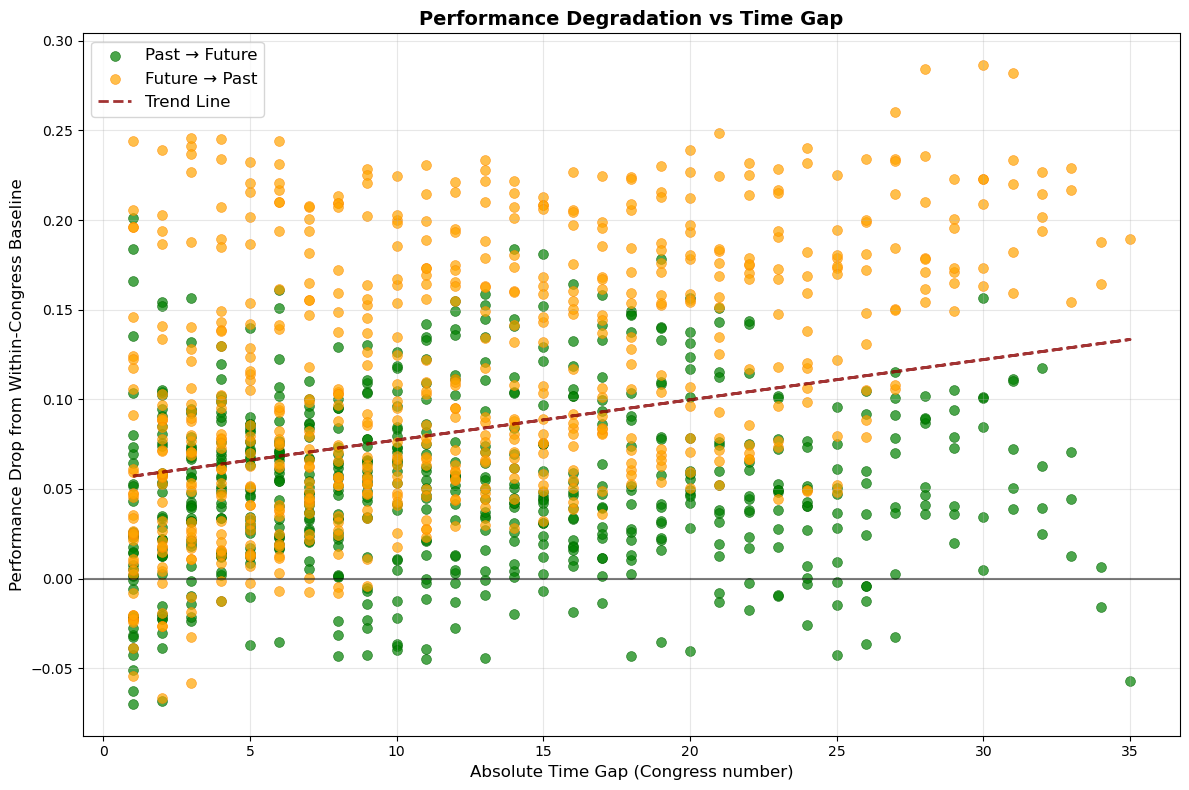

In [9]:
# Prepare data for gap analysis
df_analysis = final_df.copy()
df_analysis['abs_time_gap'] = np.abs(df_analysis['test_year'] - df_analysis['train_year'])

# Get same-year performance as baseline
same_year_baseline = final_df[final_df['train_year'] == final_df['test_year']].set_index('train_year')['accuracy']

# Calculate performance drop from baseline
df_analysis['baseline_accuracy'] = np.nan
df_analysis['performance_drop'] = np.nan

for idx, row in df_analysis.iterrows():
    train_year = row['train_year']
    test_year = row['test_year']
    
    if train_year == test_year:
        df_analysis.loc[idx, 'baseline_accuracy'] = row['accuracy']
        df_analysis.loc[idx, 'performance_drop'] = 0.0
    else:
        if train_year in same_year_baseline.index:
            baseline = same_year_baseline[train_year]
            df_analysis.loc[idx, 'baseline_accuracy'] = baseline
            df_analysis.loc[idx, 'performance_drop'] = baseline - row['accuracy']

# Filter cross-year data
cross_year_data = df_analysis[df_analysis['abs_time_gap'] > 0]
valid_drops = cross_year_data.dropna(subset=['performance_drop'])

# Create scatter plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

if not valid_drops.empty:
    # Calculate actual time gap for color coding
    valid_drops_copy = valid_drops.copy()
    valid_drops_copy['actual_time_gap'] = valid_drops_copy['test_year'] - valid_drops_copy['train_year']
    
    # Get maximum gap for normalization
    max_gap = valid_drops_copy['abs_time_gap'].max()
    
    # Separate positive and negative gaps
    positive_gaps = valid_drops_copy[valid_drops_copy['actual_time_gap'] > 0]
    negative_gaps = valid_drops_copy[valid_drops_copy['actual_time_gap'] < 0]
    
    # Plot positive gaps in solid green (Train on Past → Test on Future)
    if not positive_gaps.empty:
        ax.scatter(positive_gaps['abs_time_gap'], positive_gaps['performance_drop'], 
                  alpha=0.7, s=50, c='green', 
                  label='Past → Future', edgecolors='darkgreen', linewidth=0.5)
    
    # Plot negative gaps in solid orange (Train on Future → Test on Past)
    if not negative_gaps.empty:
        ax.scatter(negative_gaps['abs_time_gap'], negative_gaps['performance_drop'], 
                  alpha=0.7, s=50, c='orange', 
                  label='Future → Past', edgecolors='darkorange', linewidth=0.5)
    
    # Add trend line
    if len(valid_drops) > 1:
        z = np.polyfit(valid_drops['abs_time_gap'], valid_drops['performance_drop'], 1)
        p = np.poly1d(z)
        ax.plot(valid_drops['abs_time_gap'], p(valid_drops['abs_time_gap']), 
               "darkred", linestyle='--', alpha=0.8, linewidth=2, label='Trend Line')
    
    # Use simple legend with standard scatter plot legend
    ax.legend(loc='best', fontsize=12)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax.set_xlabel('Absolute Time Gap (Congress number)', fontsize=12)
ax.set_ylabel('Performance Drop from Within-Congress Baseline', fontsize=12)
ax.set_title('Performance Degradation vs Time Gap', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

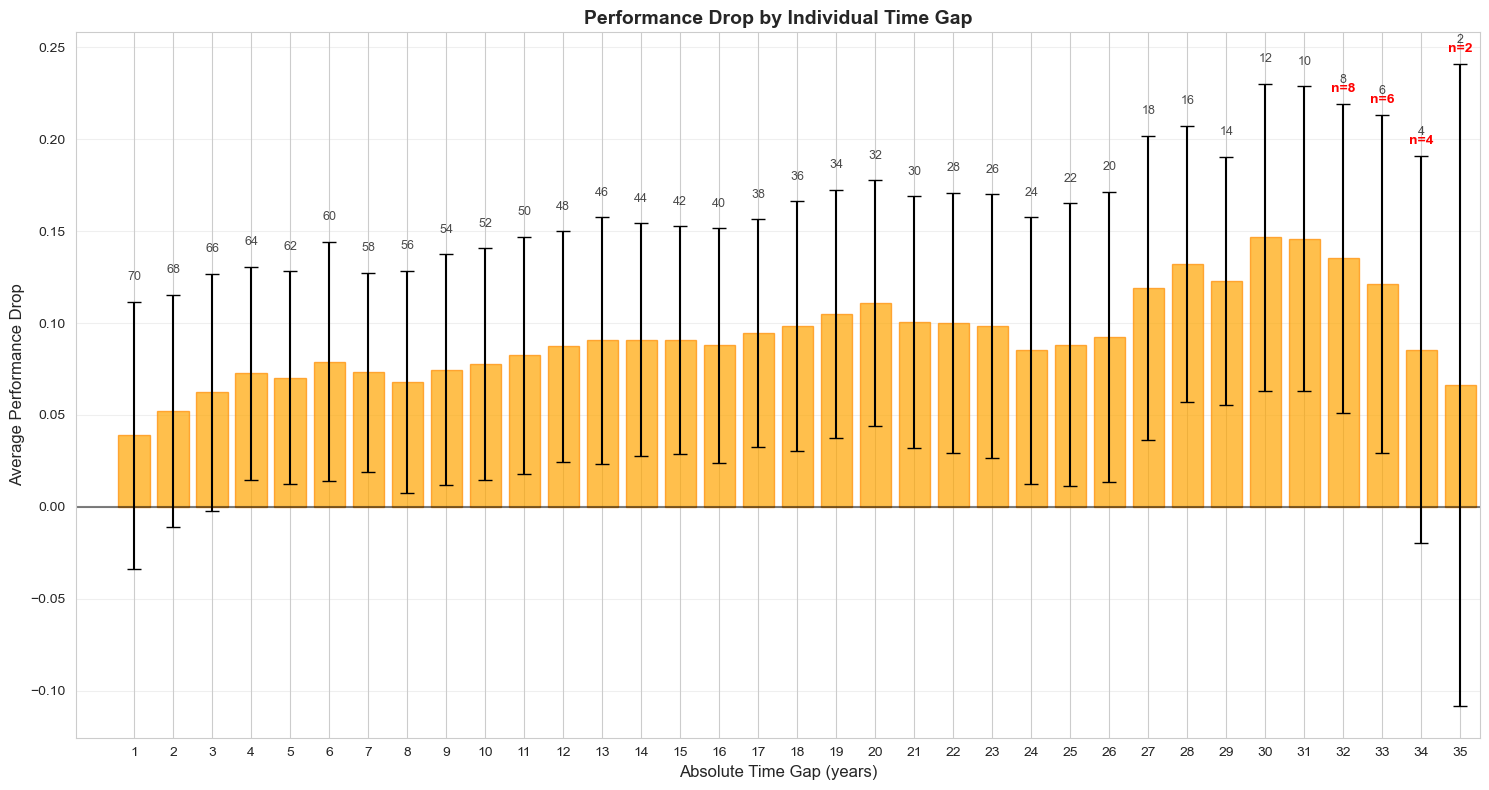

Bar plot completed. Generated statistics for 35 unique time gaps.


In [18]:
# Use the same data preparation from previous block, assuming df_analysis and cross_year_data are already prepared

# Filter valid drops
valid_drops = cross_year_data.dropna(subset=['performance_drop'])

# Create bar plot
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

if not valid_drops.empty:
    # Calculate statistics by individual gap
    gap_stats = valid_drops.groupby('abs_time_gap').agg({
        'performance_drop': ['mean', 'std', 'count'],
        'accuracy': 'mean'
    }).round(4)
    
    gap_stats.columns = ['drop_mean', 'drop_std', 'count', 'acc_mean']
    gap_stats = gap_stats.reset_index()
    
    # Create bar plot with error bars
    bars = ax.bar(gap_stats['abs_time_gap'], gap_stats['drop_mean'], 
                  yerr=gap_stats['drop_std'], 
                  alpha=0.7, color='orange', capsize=5, 
                  edgecolor='darkorange', linewidth=1)
    
    # Add sample size annotations for small samples
    for _, row in gap_stats.iterrows():
        if row['count'] < 10:  # Only label small sample sizes
            ax.text(row['abs_time_gap'], 
                   row['drop_mean'] + (row['drop_std'] if pd.notna(row['drop_std']) else 0) + 0.005, 
                   f'n={int(row["count"])}', ha='center', va='bottom', 
                   fontsize=10, color='red', fontweight='bold')
    
    # Add sample size for all bars on top
    for i, (_, row) in enumerate(gap_stats.iterrows()):
        height = row['drop_mean'] + (row['drop_std'] if pd.notna(row['drop_std']) else 0)
        ax.text(row['abs_time_gap'], height + 0.01, 
               f'{int(row["count"])}', ha='center', va='bottom', 
               fontsize=9, color='black', alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax.set_xlabel('Absolute Time Gap (years)', fontsize=12)
ax.set_ylabel('Average Performance Drop', fontsize=12)
ax.set_title('Performance Drop by Individual Time Gap', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Set x-axis to show all time gaps
if not gap_stats.empty:
    ax.set_xticks(gap_stats['abs_time_gap'])
    ax.set_xlim(-0.5, gap_stats['abs_time_gap'].max() + 0.5)

plt.tight_layout()
plt.show()

# Store gap_stats for the next block
print(f"Bar plot completed. Generated statistics for {len(gap_stats)} unique time gaps.")

In [20]:
# Calculate gap statistics (using data from previous blocks)
valid_drops = cross_year_data.dropna(subset=['performance_drop'])

if not valid_drops.empty:
    # Calculate statistics by individual gap
    gap_stats = valid_drops.groupby('abs_time_gap').agg({
        'performance_drop': ['mean', 'std', 'count'],
        'accuracy': 'mean'
    }).round(4)
    
    gap_stats.columns = ['drop_mean', 'drop_std', 'count', 'acc_mean']
    gap_stats = gap_stats.reset_index()
    
    # Format for display
    display_stats = gap_stats.copy()
    display_stats['drop_mean'] = display_stats['drop_mean'].round(4)
    display_stats['drop_std'] = display_stats['drop_std'].round(4)
    display_stats['acc_mean'] = display_stats['acc_mean'].round(4)
    display_stats['count'] = display_stats['count'].astype(int)
    
    # Rename columns for better display
    display_stats.columns = ['Time_Gap', 'Avg_Performance_Drop', 'Std_Performance_Drop', 'Sample_Count', 'Avg_Accuracy']
    
    # Print formatted table
    print("="*80)
    print("GAP ANALYSIS RESULTS (Individual Time Gaps)")
    print("="*80)
    print(display_stats.to_string(index=False))
    
    # Calculate and print summary insights
    print(f"\n📊 SUMMARY INSIGHTS:")
    print(f"   Total unique time gaps: {len(gap_stats)}")
    print(f"   Gaps with only 1 sample: {len(gap_stats[gap_stats['count'] == 1])}")
    print(f"   Gaps with ≤3 samples: {len(gap_stats[gap_stats['count'] <= 3])}")
    print(f"   Gaps with >5 samples: {len(gap_stats[gap_stats['count'] > 5])}")
    print(f"   Maximum performance drop: {gap_stats['drop_mean'].max():.4f} (at {gap_stats.loc[gap_stats['drop_mean'].idxmax(), 'abs_time_gap']:.0f} year gap)")
    print(f"   Minimum performance drop: {gap_stats['drop_mean'].min():.4f} (at {gap_stats.loc[gap_stats['drop_mean'].idxmin(), 'abs_time_gap']:.0f} year gap)")
    
    # Additional statistics
    cross_year_total = len(cross_year_data)
    valid_comparisons = len(valid_drops)
    
    print(f"\n📈 DATA QUALITY METRICS:")
    print(f"   Total cross-year combinations: {cross_year_total}")
    print(f"   Valid baseline comparisons: {valid_comparisons}")
    print(f"   Coverage: {(valid_comparisons/cross_year_total)*100:.1f}% of cross-year combinations have baselines")
    
    # Time gap distribution
    gap_distribution = cross_year_data['abs_time_gap'].describe()
    print(f"\n⏱️  TIME GAP DISTRIBUTION:")
    print(f"   Mean gap: {gap_distribution['mean']:.1f} years")
    print(f"   Median gap: {gap_distribution['50%']:.1f} years")
    print(f"   Max gap: {gap_distribution['max']:.0f} years")
    print(f"   Most common gap: {cross_year_data['abs_time_gap'].mode().iloc[0]:.0f} years")
    
    print("="*80)
    
else:
    print("No gap analysis data available.")

GAP ANALYSIS RESULTS (Individual Time Gaps)
 Time_Gap  Avg_Performance_Drop  Std_Performance_Drop  Sample_Count  Avg_Accuracy
        1                0.0389                0.0727            70        0.5854
        2                0.0522                0.0633            68        0.5712
        3                0.0623                0.0646            66        0.5608
        4                0.0726                0.0581            64        0.5500
        5                0.0703                0.0579            62        0.5520
        6                0.0790                0.0652            60        0.5434
        7                0.0731                0.0543            58        0.5498
        8                0.0679                0.0606            56        0.5555
        9                0.0746                0.0628            54        0.5490
       10                0.0778                0.0631            52        0.5467
       11                0.0825                0.0646 

In [8]:
# Block 3: Enhanced Data Analysis - Positive vs Negative Time Gap Statistics
import pandas as pd
import numpy as np

# Calculate gap statistics with positive/negative separation
valid_drops = cross_year_data.dropna(subset=['performance_drop'])

if not valid_drops.empty:
    # Add actual time gap (with sign) to differentiate direction
    valid_drops_analysis = valid_drops.copy()
    valid_drops_analysis['actual_time_gap'] = valid_drops_analysis['test_year'] - valid_drops_analysis['train_year']
    
    # Separate positive and negative gaps
    positive_gaps = valid_drops_analysis[valid_drops_analysis['actual_time_gap'] > 0]
    negative_gaps = valid_drops_analysis[valid_drops_analysis['actual_time_gap'] < 0]
    
    # POSITIVE GAPS ANALYSIS (Train on Past, Test on Future)
    if not positive_gaps.empty:
        pos_gap_stats = positive_gaps.groupby('abs_time_gap').agg({
            'performance_drop': ['mean', 'std', 'count'],
            'accuracy': 'mean'
        }).round(4)
        
        pos_gap_stats.columns = ['drop_mean', 'drop_std', 'count', 'acc_mean']
        pos_gap_stats = pos_gap_stats.reset_index()
        
        # Format for display (handle NaN values in std)
        pos_display_stats = pos_gap_stats.copy()
        pos_display_stats['drop_mean'] = pos_display_stats['drop_mean'].round(4)
        pos_display_stats['drop_std'] = pos_display_stats['drop_std'].fillna(0).round(4)  # Fill NaN with 0
        pos_display_stats['acc_mean'] = pos_display_stats['acc_mean'].round(4)
        pos_display_stats['count'] = pos_display_stats['count'].astype(int)
        pos_display_stats.columns = ['Time_Gap', 'Avg_Performance_Drop', 'Std_Performance_Drop', 'Sample_Count', 'Avg_Accuracy']
        
        print("\n POSITIVE TIME GAPS (Train on Past → Test on Future)")
        print("-" * 70)
        print(pos_display_stats.to_string(index=False))
        
        # Positive gaps insights
        print(f"\n📊 POSITIVE GAPS INSIGHTS:")
        print(f"   Total positive gap combinations: {len(positive_gaps)}")
        print(f"   Unique positive gap values: {len(pos_gap_stats)}")
        print(f"   Average performance drop: {positive_gaps['performance_drop'].mean():.4f}")
        max_drop_idx = pos_gap_stats['drop_mean'].idxmax()
        min_drop_idx = pos_gap_stats['drop_mean'].idxmin()
        print(f"   Max performance drop: {pos_gap_stats['drop_mean'].max():.4f} (at {pos_gap_stats.iloc[max_drop_idx]['abs_time_gap']:.0f} year gap)")
        print(f"   Min performance drop: {pos_gap_stats['drop_mean'].min():.4f} (at {pos_gap_stats.iloc[min_drop_idx]['abs_time_gap']:.0f} year gap)")
        print(f"   Gaps with ≤3 samples: {len(pos_gap_stats[pos_gap_stats['count'] <= 3])}")
        print(f"   Gaps with >5 samples: {len(pos_gap_stats[pos_gap_stats['count'] > 5])}")
    
    # NEGATIVE GAPS ANALYSIS (Train on Future, Test on Past)
    if not negative_gaps.empty:
        neg_gap_stats = negative_gaps.groupby('abs_time_gap').agg({
            'performance_drop': ['mean', 'std', 'count'],
            'accuracy': 'mean'
        }).round(4)
        
        neg_gap_stats.columns = ['drop_mean', 'drop_std', 'count', 'acc_mean']
        neg_gap_stats = neg_gap_stats.reset_index()
        
        # Format for display (handle NaN values in std)
        neg_display_stats = neg_gap_stats.copy()
        neg_display_stats['drop_mean'] = neg_display_stats['drop_mean'].round(4)
        neg_display_stats['drop_std'] = neg_display_stats['drop_std'].fillna(0).round(4)  # Fill NaN with 0
        neg_display_stats['acc_mean'] = neg_display_stats['acc_mean'].round(4)
        neg_display_stats['count'] = neg_display_stats['count'].astype(int)
        neg_display_stats.columns = ['Time_Gap', 'Avg_Performance_Drop', 'Std_Performance_Drop', 'Sample_Count', 'Avg_Accuracy']
        
        print("\n\n NEGATIVE TIME GAPS (Train on Future → Test on Past)")
        print("-" * 70)
        print(neg_display_stats.to_string(index=False))
        
        # Negative gaps insights
        print(f"\n📊 NEGATIVE GAPS INSIGHTS:")
        print(f"   Total negative gap combinations: {len(negative_gaps)}")
        print(f"   Unique negative gap values: {len(neg_gap_stats)}")
        print(f"   Average performance drop: {negative_gaps['performance_drop'].mean():.4f}")
        max_drop_idx = neg_gap_stats['drop_mean'].idxmax()
        min_drop_idx = neg_gap_stats['drop_mean'].idxmin()
        print(f"   Max performance drop: {neg_gap_stats['drop_mean'].max():.4f} (at {neg_gap_stats.iloc[max_drop_idx]['abs_time_gap']:.0f} year gap)")
        print(f"   Min performance drop: {neg_gap_stats['drop_mean'].min():.4f} (at {neg_gap_stats.iloc[min_drop_idx]['abs_time_gap']:.0f} year gap)")
        print(f"   Gaps with ≤3 samples: {len(neg_gap_stats[neg_gap_stats['count'] <= 3])}")
        print(f"   Gaps with >5 samples: {len(neg_gap_stats[neg_gap_stats['count'] > 5])}")
    
    # COMPARATIVE ANALYSIS
    print(f"\n\n🔄 COMPARATIVE ANALYSIS (Positive vs Negative)")
    print("-" * 70)
    
    if not positive_gaps.empty and not negative_gaps.empty:
        pos_avg_drop = positive_gaps['performance_drop'].mean()
        neg_avg_drop = negative_gaps['performance_drop'].mean()
        
        print(f"   Average Performance Drop:")
        print(f"     Positive gaps (Past→Future): {pos_avg_drop:.4f}")
        print(f"     Negative gaps (Future→Past): {neg_avg_drop:.4f}")
        print(f"     Difference: {abs(pos_avg_drop - neg_avg_drop):.4f}")
        
        if pos_avg_drop > neg_avg_drop:
            print(f"     → Training on past data and testing on future shows HIGHER degradation")
        else:
            print(f"     → Training on future data and testing on past shows HIGHER degradation")
        
        # Compare variability
        pos_std = positive_gaps['performance_drop'].std()
        neg_std = negative_gaps['performance_drop'].std()
        print(f"\n   Performance Drop Variability:")
        print(f"     Positive gaps std: {pos_std:.4f}")
        print(f"     Negative gaps std: {neg_std:.4f}")
        
        # Compare coverage
        print(f"\n   Data Coverage:")
        print(f"     Positive gap combinations: {len(positive_gaps)} ({len(positive_gaps)/len(valid_drops)*100:.1f}%)")
        print(f"     Negative gap combinations: {len(negative_gaps)} ({len(negative_gaps)/len(valid_drops)*100:.1f}%)")
        
        # Time range analysis
        cross_year_total = len(cross_year_data)
        pos_max_gap = positive_gaps['abs_time_gap'].max()
        neg_max_gap = negative_gaps['abs_time_gap'].max()
        print(f"\n   Time Range Coverage:")
        print(f"   Total cross-year combinations: {cross_year_total}")
        print(f"     Max positive gap: {pos_max_gap:.0f} years")
        print(f"     Max negative gap: {neg_max_gap:.0f} years")
    print("="*90)
    
else:
    print("No gap analysis data available.")


 POSITIVE TIME GAPS (Train on Past → Test on Future)
----------------------------------------------------------------------
 Time_Gap  Avg_Performance_Drop  Std_Performance_Drop  Sample_Count  Avg_Accuracy
        1                0.0266                0.0677            35        0.5947
        2                0.0397                0.0541            34        0.5786
        3                0.0467                0.0410            33        0.5686
        4                0.0567                0.0376            32        0.5557
        5                0.0515                0.0357            31        0.5597
        6                0.0606                0.0411            30        0.5492
        7                0.0528                0.0289            29        0.5562
        8                0.0427                0.0412            28        0.5633
        9                0.0484                0.0459            27        0.5554
       10                0.0498                0.0504  